In [1]:
#%matplotlib inline
%matplotlib notebook
import instrument
import numpy as np
import time
import matplotlib.pyplot as plt
import pickle as pickle
import os
from math import pi
import glob

In [239]:
#series_list=[]

Connected to Agilent Technologies,DSO1012A,CN50301202,00.04.06 SP05

Tau is (1.65 +/- 0.00)us with std 0.04us


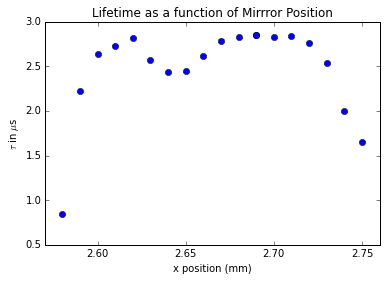

In [275]:
position=(2.75,1.75)

reload(instrument)
scope=instrument.AgilentScope("/dev/usbtmc0")
tau_mean,tau_uncertainty,series=scope.measure_tau(100)
series.position=position
series_list.append(series)

# j=0
# for series in series_list:
#     file_name='horizontal_scan_%d_%1.2fmm.pkl' % (j,series.position[0])
#     file_name=os.path.join('Mirrors_3_4_Horizontal_Scan_1',file_name)
#     series.file_name=file_name
#     series.save(overwrite=True)

x_array=np.array([series.position[0] for series in series_list])
tau_array=np.array([series.tau_mean for series in series_list])*1e6
tau_uncertainties=np.array([series.tau_uncertainty for series in series_list])*1e6
left_lim,right_lim=min(x_array)-0.01,max(x_array)+0.01
plt.errorbar(x_array,tau_array,yerr=tau_uncertainties,fmt='o')
plt.xlim(left_lim,right_lim)
plt.xlabel(r"x position (mm)")
plt.ylabel(r"$\tau$ in $\mu$s")
plt.title(r"Lifetime as a function of Mirrror Position")
# plt.savefig("Ringdown_Data/Mirrors_3_4_Horizontal_Scan_1/plot.png")

In [32]:
#file_pattern='./Ringdown_Data/Mirrors_1_2_Horizontal_Scan_2/horizontal_scan*.pkl'
#file_pattern='./Ringdown_Data/Mirrors_3_4_Horizontal_Scan_1/horizontal_scan*.pkl'
#file_pattern='./Ringdown_Data/2015_9_23/First Monika Ringdowns.pkl'
file_pattern='./Ringdown_Data/2015_9_28/Mixed_2015_3_and_Monika_1_take_*.pkl'

file_list=glob.glob(file_pattern)
tau_list=[]
series_list=[]
for one_file in file_list:
    one_file=one_file[16:] #Remove ./Ringdown_Data
    series=instrument.Measurement_Series.load_updated(one_file)
    tau_list.append((series.tau_mean,series.tau_uncertainty))
    series_list.append(series)
tau_list.sort()
tau_max=tau_list[-1]
print tau_max
print
for tau_tuple in tau_list[-3:]:
    print tau_tuple

(3.9208419585494327e-06, 9.0881225547176588e-08)

(2.4743229378413124e-06, 1.2916186458809404e-08)
(3.7226209904035903e-06, 4.2515816208200787e-08)
(3.9208419585494327e-06, 9.0881225547176588e-08)


In [22]:
def chart_line(T1,T2,tau):
    """Given T1,T2 in ppm and tau in us, returns a bunch of info"""
    T1=T1*1e-6
    T2=T2*1e-6
    tau=tau*1e-6
    L=0.044 #cavity length (m)
    w0=45e-6 #cavity waist (m)
    c=2.9979e8 #speed of light (m/s)
    k=2*pi/780e-9 #wave vector magnitude (1/m)
    leakage=2*L/(c*tau)
    F=2*pi/leakage
    l1_l2=leakage-T1-T2
    T_l_ratio=(T1+T2)/(l1_l2)
    eta=24*(F/pi)/(k**2*w0**2)
    return (T1*1e6,T2*1e6,tau*1e6,F,eta,leakage*1e6,T_l_ratio)

chart_line(6,5,10.3)

(6.0,
 5.0,
 10.299999999999999,
 220471.04624278971,
 12.817914583066257,
 28.498913640843085,
 0.6286104512411336)

<IPython.core.display.Javascript object>


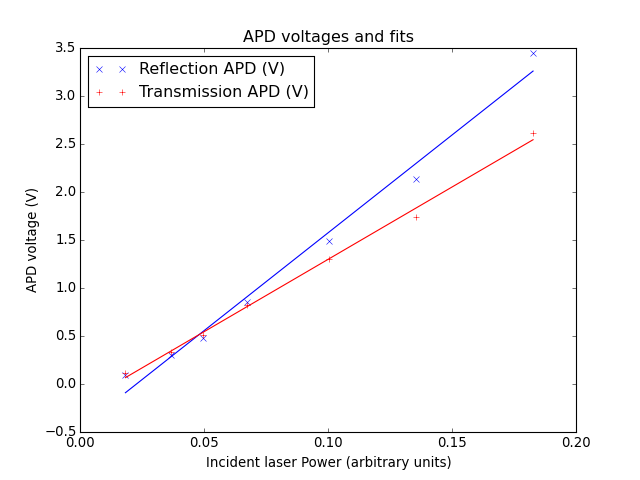

<IPython.core.display.Javascript object>


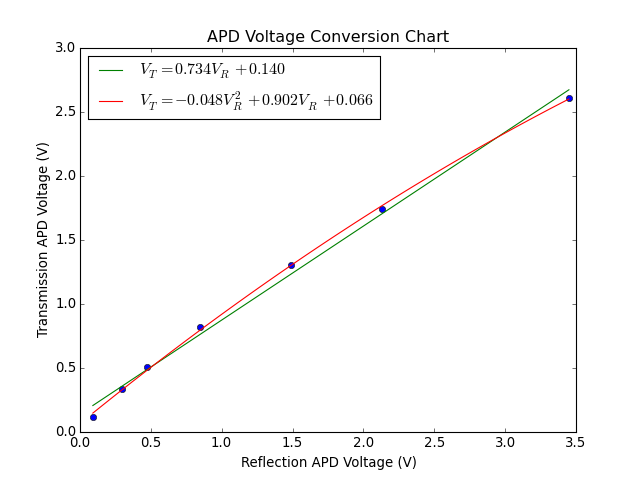

0

In [16]:
ODs=np.array([1.7,2.7,4.0,3.3,3.0,2.0,2.3])
reflection_APD_voltages=np.array([3.43+0.02, 0.829+0.021, 0.0696+0.0211,
                                  0.278+0.021, 0.4543+0.021, 2.11+0.021, 1.47+0.021])
transmission_APD_voltages=np.array([2.63-0.02, 0.838-0.018, 0.1331-0.018,
                                    0.3561-0.0179, 0.525-0.0179,1.76-0.018, 1.32-0.018])

#Make these plots interactive
%matplotlib notebook

#Sort data
data=np.vstack([ODs,reflection_APD_voltages,transmission_APD_voltages])
data=np.vstack([ODs,reflection_APD_voltages,transmission_APD_voltages])
data=np.transpose(data)[np.argsort(data[0,:])]
data=np.transpose(data)
ODs,reflection_APD_voltages,transmission_APD_voltages=data

#Calculate some basic things
powers=np.exp(-1.*ODs)
ratios=reflection_APD_voltages/transmission_APD_voltages

#Linearly fit reflection APD data
r_fit = np.polyfit(powers,reflection_APD_voltages,1)
r_fit_fn = np.poly1d(r_fit) 
r_fit_voltages=r_fit_fn(powers)

#Linearly fit transmission APD data
t_fit = np.polyfit(powers,transmission_APD_voltages,1)
t_fit_fn = np.poly1d(t_fit) 
t_fit_voltages=t_fit_fn(powers)

#Plot data and fits
plt.figure()
plt.plot(powers,reflection_APD_voltages,color='blue',marker='x',ls='',label='Reflection APD (V)')
plt.plot(powers,r_fit_voltages,color='blue')
plt.plot(powers,transmission_APD_voltages,color='red',marker='+',ls='',label='Transmission APD (V)')
plt.plot(powers,t_fit_voltages,color='red')

#Make plot understandable
plt.title("APD voltages and fits")
plt.xlabel('Incident laser Power (arbitrary units)')
plt.ylabel('APD voltage (V)')
plt.legend(loc=0)
plt.savefig('Ringdown_Data/APD_Calibration/Responses.png')



#Now let's look at how to convert from reflection to transmission
fit_x=np.linspace(min(reflection_APD_voltages),max(reflection_APD_voltages))
fit1 = np.polyfit(reflection_APD_voltages,transmission_APD_voltages,1)
fit1_fn = np.poly1d(fit1) 
fit1_voltages=fit1_fn(fit_x)
fit2=np.polyfit(reflection_APD_voltages,transmission_APD_voltages,2)
fit2_fn=np.poly1d(fit2)
fit2_voltages=fit2_fn(fit_x)

#Plot results
plt.figure()
plt.plot(reflection_APD_voltages,transmission_APD_voltages,marker='o',linestyle='')
plt.plot(fit_x,fit1_voltages,label='$V_T=%.3f V_R+%.3f$' % tuple(fit1))
plt.plot(fit_x,fit2_voltages,label='$V_T=%.3f V_R^2 +%.3fV_R+%.3f$' % tuple(fit2))

#Make plot understandable
plt.title('APD Voltage Conversion Chart')
plt.xlabel('Reflection APD Voltage (V)')
plt.ylabel('Transmission APD Voltage (V)')
plt.legend(loc=0);
plt.savefig('Ringdown_Data/APD_Calibration/Conversion.png')

#Combine plots
os.system("cd Ringdown_Data/APD_Calibration && " + 
           "convert Responses.png Conversion.png -append APD_Plots.png");



##Start looking at the APD voltage ratios and show fits
#plt.figure()
#
##Linear fit
#fit_x=np.linspace(min(powers),max(powers))
#fit1=np.polyfit(powers,ratios,1)
#fit1_fn=np.poly1d(fit1)
#fit1_y=fit1_fn(fit_x)
#
##Quadratic fit
#fit2=np.polyfit(powers,ratios,2)
#fit2_fn=np.poly1d(fit2)
#fit2_y=fit2_fn(fit_x)
#
#plt.plot(powers,ratios,marker='o',linestyle='')
#plt.plot(fit_x,fit1_y,label='linear fit');
#plt.plot(fit_x,fit2_y,label='quadratic fit');
#
#plt.title('Ratio of Ref/Trans APD voltages')
#plt.xlabel('Incident laser Power (arbitrary units)')
#plt.ylabel('Ratio')
#plt.legend(loc=0);

#Return to using non-interactive plots
#%matplotlib inline

Connected to Agilent Technologies,DSO1012A,CN50301202,00.04.06 SP05

Tau is (2.78 +/- 0.01)us with std 0.15us


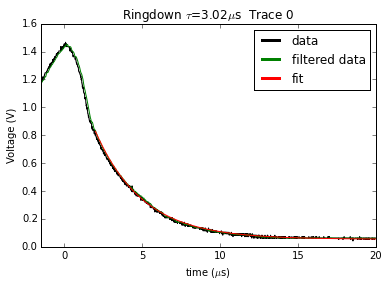

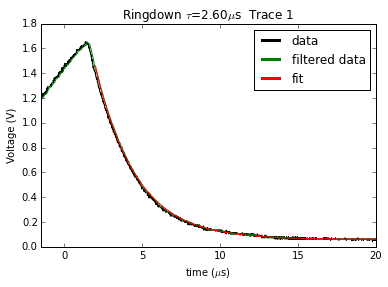

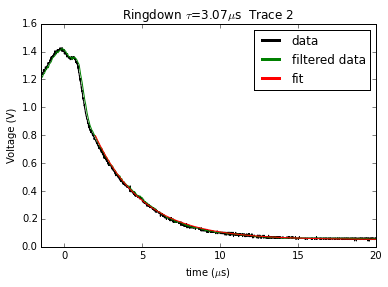

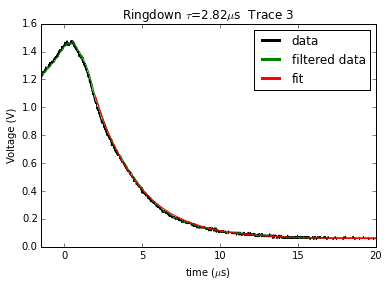

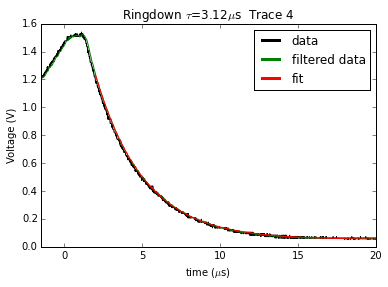

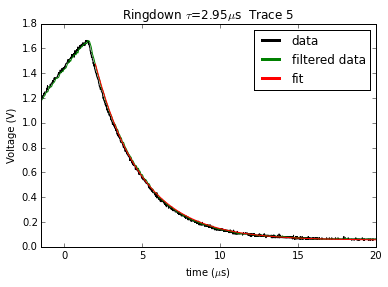

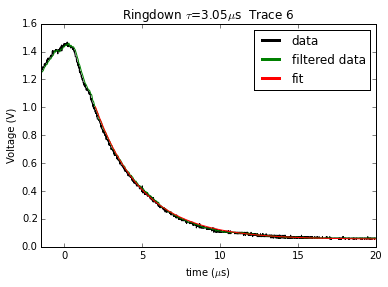

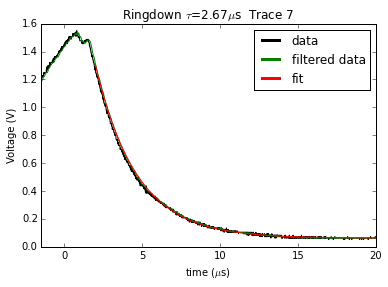

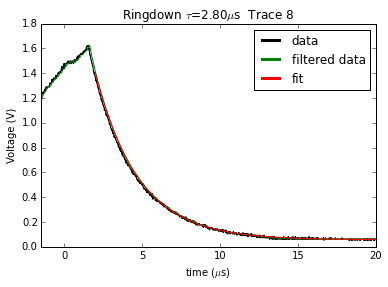

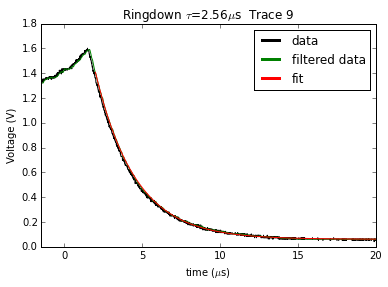

In [92]:
%matplotlib inline
n_traces=100

reload(instrument)
scope=instrument.AgilentScope("/dev/usbtmc0")
tau_mean,tau_uncertainty,series=scope.measure_tau(n_traces)

for j in range(10):
    series.plot_ringdown(j)
    
series.file_name='Mirrors_3_4_take_2.pkl'
series.save()

In [93]:
#Measured Parameters
reflection_dip= 0.740 #Amplitude of dip in reflection on resonance measured with AC coupling (Volts)
transmission_peak=2.06 #Peak transmission on resonance measured with AC coupling (Volts)
V_off_resonance=1.11 #DC voltage at reflection APD when off resonance(Volts)
tau=2.78e-6 #Cavity decay time (seconds)
splitter_factor=2.79 #1/(fraction of power picked off by beam splitter)

#Constants
L=0.044 #cavity length (m)
c=2.9979e8 #speed of light (m/s)

#Normalize reflection amplitude
P_R_frac=1-(reflection_dip/V_off_resonance)

#Normalize transmition amplitude
#Convert between APD scales to calculate voltage at transmission APD
V_T_converted=-0.0484*V_off_resonance**2+0.902*V_off_resonance+0.066 #Quadratic conversion
# V_T_max=0.734*V_off_resonance+0.140 #Linear conversion
V_T_max=splitter_factor*V_T_converted #Effective voltage at reflection APD accounting for beamsplitter
P_T_frac=transmission_peak/V_T_max

#Calculate power parameter
P_param=P_T_frac/(1-P_R_frac)

#Calculate finesse
FSR=c/(2.*L) #free spectral range (Hz)
# finesse=0.5*tau*FSR
finesse=2*pi*FSR*tau

#Calculate loss and transmission per mirror, assuming they are the same for each mirror
l=(1-P_param)/(1+P_param)*(pi/finesse)
T=2*P_param/(1+P_param)*(pi/finesse)
epsilon=(P_T_frac)/(T**2*(finesse/pi)**2)
l=l*1e6 #Convert to ppm at end
T=T*1e6 #Convert to ppm at end

print l
print T
print epsilon

-2.49458741217
55.2893375022
0.668158414509


Connected to Agilent Technologies,DSO1012A,CN50301202,00.04.06 SP05

Tau is (2.89 +/- 0.01)us with std 0.11us


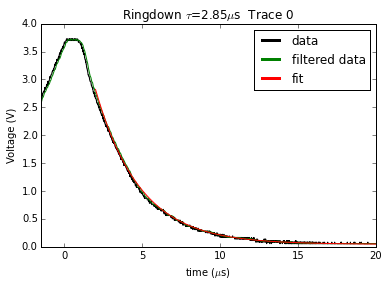

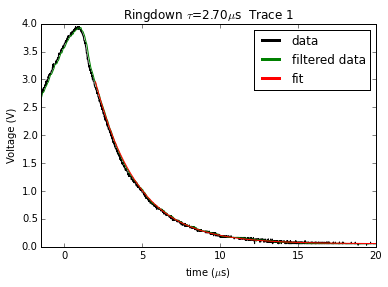

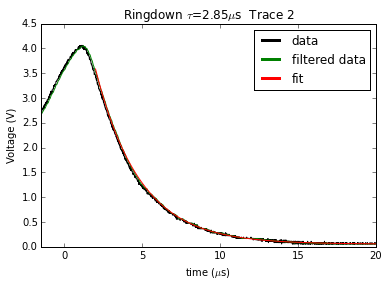

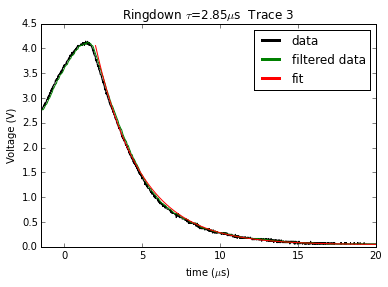

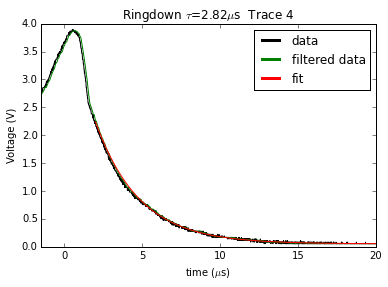

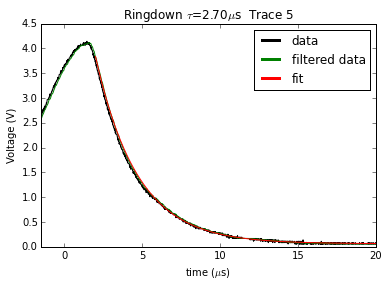

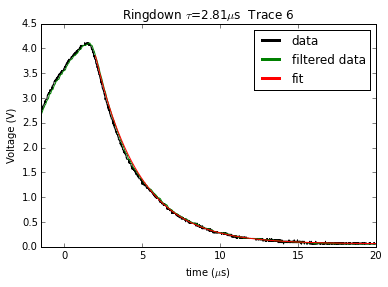

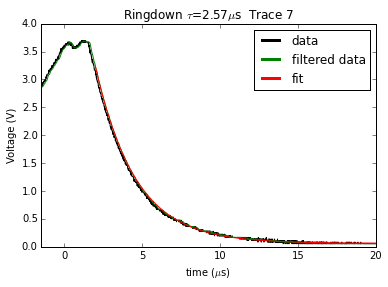

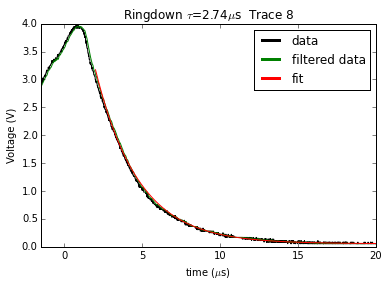

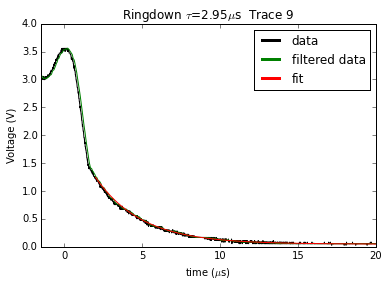

In [95]:
%matplotlib inline
n_traces=100

reload(instrument)
scope=instrument.AgilentScope("/dev/usbtmc0")
tau_mean,tau_uncertainty,series=scope.measure_tau(n_traces)

for j in range(10):
    series.plot_ringdown(j)
    
series.file_name='Mirrors_3_4_take_1.pkl'
series.save()

Connected to Agilent Technologies,DSO1012A,CN50301202,00.04.06 SP05

Tau is (10.57 +/- 0.08)us with std 0.78us


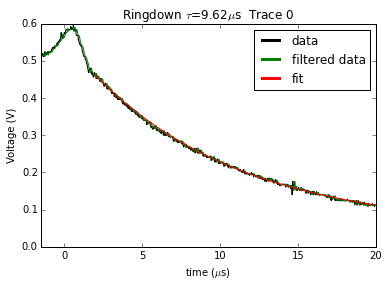

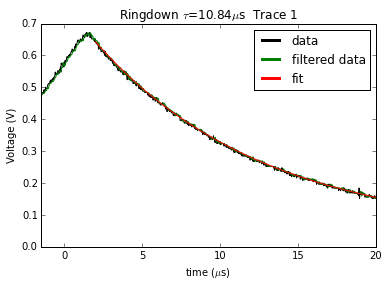

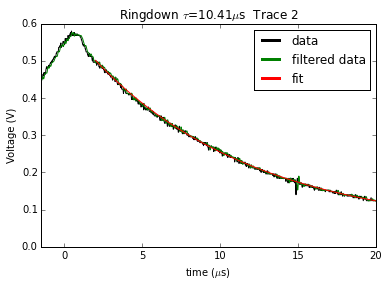

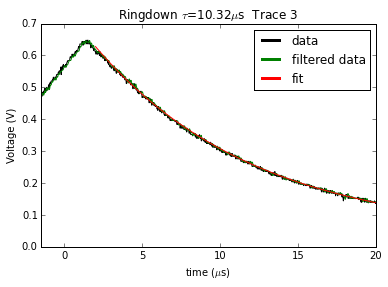

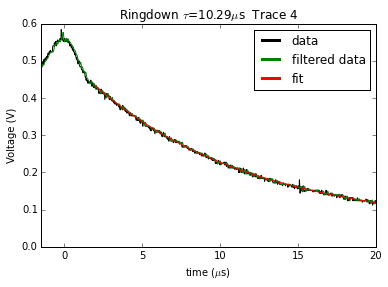

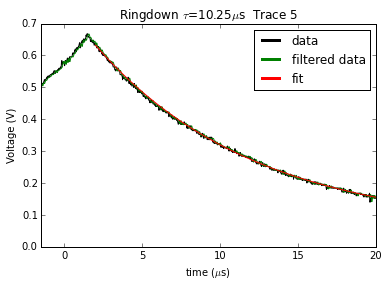

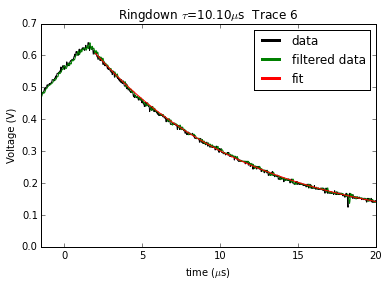

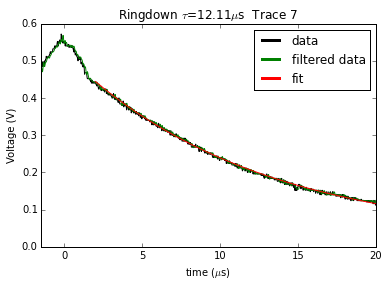

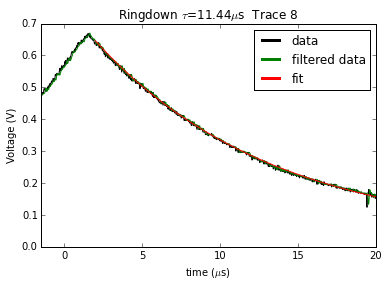

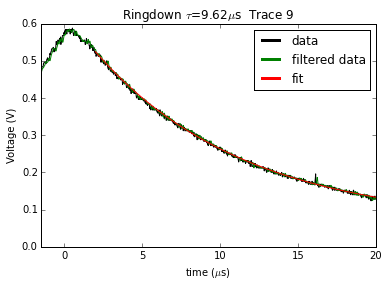

In [100]:
%matplotlib inline
n_traces=100

reload(instrument)
scope=instrument.AgilentScope("/dev/usbtmc0")
tau_mean,tau_uncertainty,series=scope.measure_tau(n_traces)

for j in range(min(n_traces,10)):
    series.plot_ringdown(j)
    
series.file_name='Mirrors_M1_M2_take_1.pkl'
series.save()

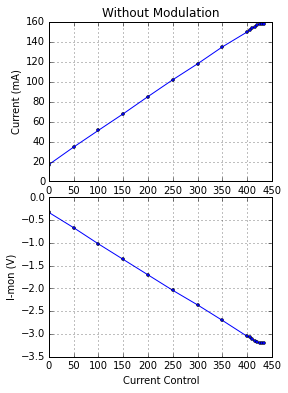

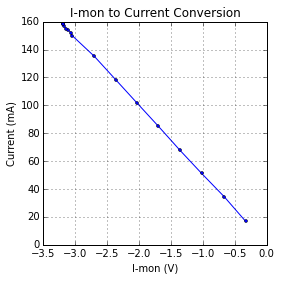

In [189]:
#%matplotlib notebook
%matplotlib inline

#Current Controller plots
knob=np.array([0,50,100,150,200,250,300,350,400,405,410,415,420,425,430,435])
current=np.array([16.8,34.4,51.2,67.8,85.1,102.,118.,135.,150.,152.,154.,155.,157.,158.,158.,158.])
i_mon=-1.*np.array([0.329,0.664,1.02,1.36,1.70,2.04,2.36,2.70,3.05,3.07,3.11,3.15,3.18,3.20,3.20,3.20])

# Two subplots, the axes array is 1-d
fig, axarr = plt.subplots(2, sharex=False,figsize=(4,6))
axarr[0].plot(knob, current,marker='o',markersize=3)
axarr[0].set_ylabel('Current (mA)')
axarr[0].grid(True)
axarr[0].set_title('Without Modulation')

axarr[1].plot(knob,i_mon,marker='o',markersize=3)
axarr[1].set_ylabel('I-mon (V)')
axarr[1].set_xlabel('Current Control')
axarr[1].grid(True)
fig.subplots_adjust(hspace=0.1)
fig.savefig('/home/zak/Desktop/Current_Controller_Plot_1.svg',bbox_inches='tight')
#plt.xlabel('test')

#Current as a function of I-mon
fig = plt.figure(figsize=(4,4))
ax=fig.add_subplot(111)
ax.plot(i_mon,current,marker='o',markersize=3)
ax.set_xlabel('I-mon (V)')
ax.set_ylabel('Current (mA)')
ax.set_title('I-mon to Current Conversion')
ax.grid(True)
fig.savefig('/home/zak/Desktop/Current_Controller_Plot_2.svg',bbox_inches='tight')



# fig = plt.figure(figsize=(4,6))
# ax1 = fig.add_subplot(2,1,1)
# ax2 = fig.add_subplot(2,1,2)
# ax1.plot(knob,current)
# ax2.plot(knob,i_mon)

Connected to Agilent Technologies,DSO1012A,CN50301202,00.04.06 SP05

Tau is (10.32 +/- 0.04)us with std 0.43us


NameError: File Ringdown_Data/Mirrors_M1_M2_take_1.pkl already exists. Set overwrite=True to overwrite it

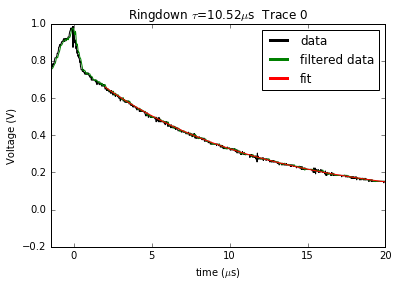

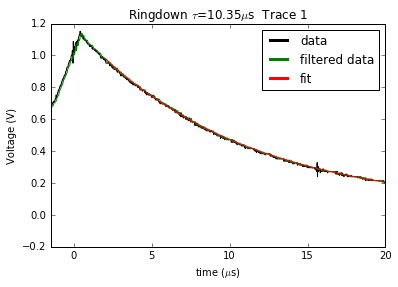

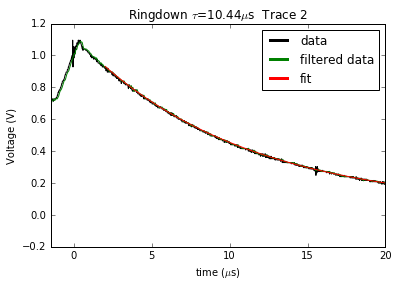

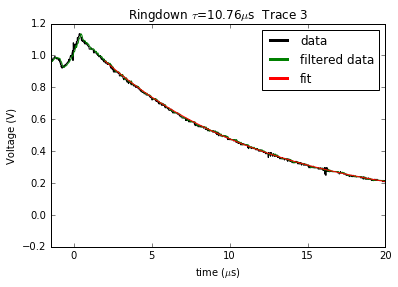

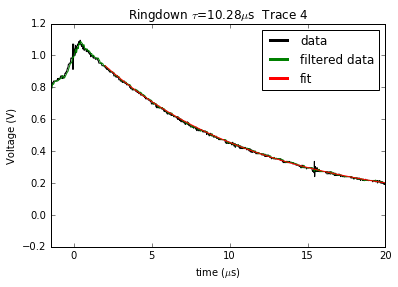

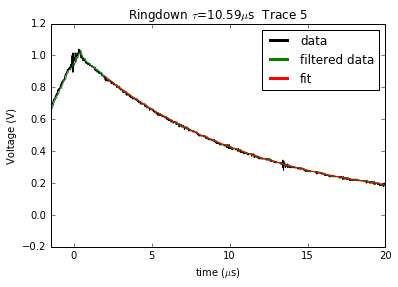

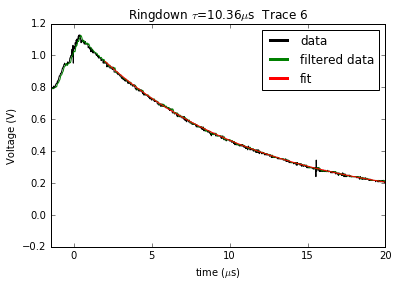

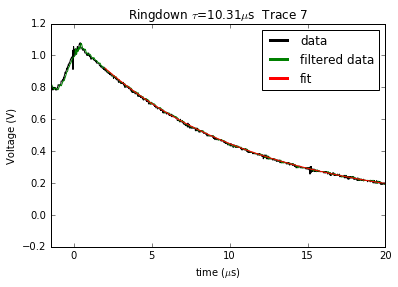

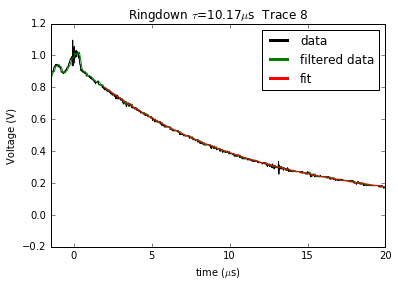

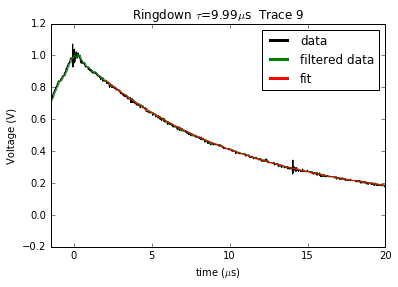

In [13]:
%matplotlib inline
n_traces=100

reload(instrument)
scope=instrument.AgilentScope("/dev/usbtmc0")
tau_mean,tau_uncertainty,series=scope.measure_tau(n_traces)

for j in range(min(n_traces,10)):
    series.plot_ringdown(j)
    
series.file_name='Mirrors_M1_M2_take_1.pkl'
series.save()

<IPython.core.display.Javascript object>


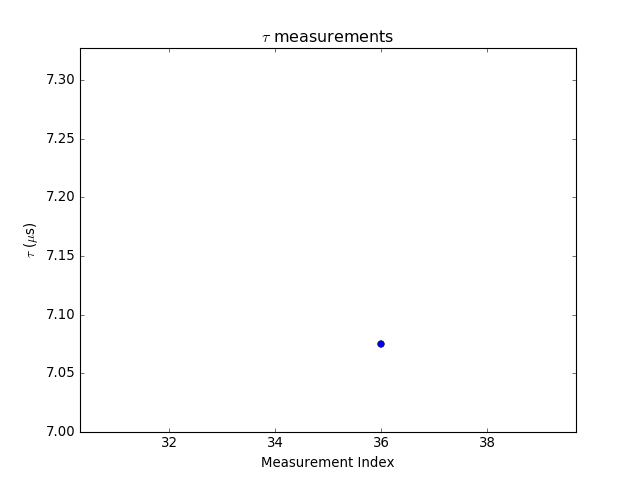

In [18]:
%matplotlib notebook
series.plot_tau_series(1)

<IPython.core.display.Javascript object>


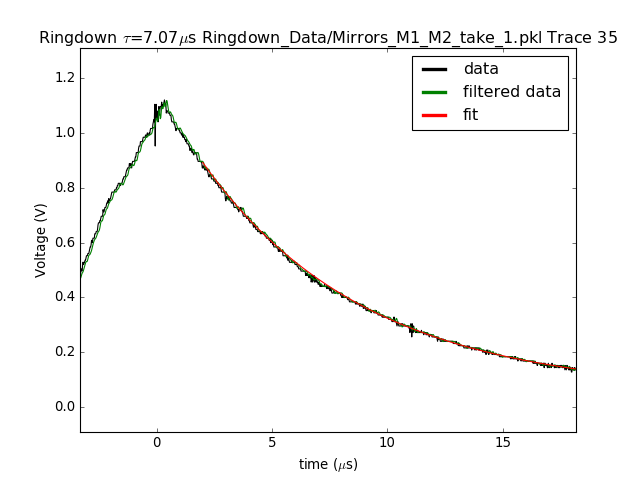

In [15]:
series.plot_ringdown(35)

<IPython.core.display.Javascript object>


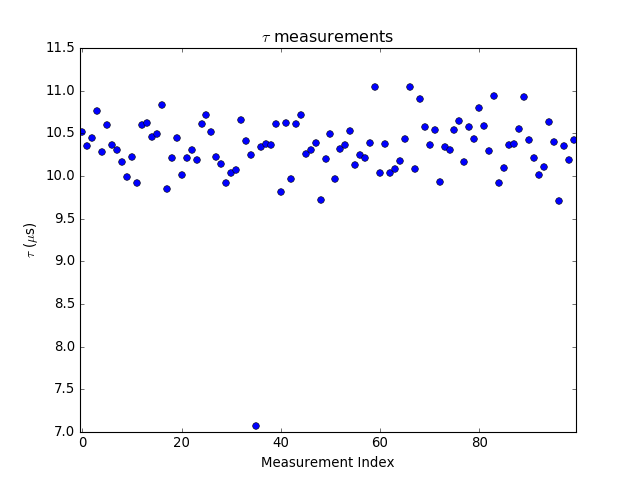

test


In [21]:
%matplotlib notebook
reload(instrument)
series2=instrument.Measurement_Series.load_updated('Mirrors_M1_M2_take_1.pkl')
series2.plot_tau_series(1)

Connected to Agilent Technologies,DSO1012A,CN50301202,00.04.06 SP05

Tau is (9.01 +/- 0.02)us with std 0.23us


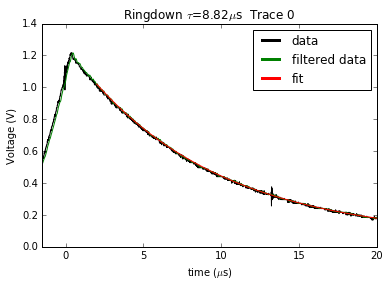

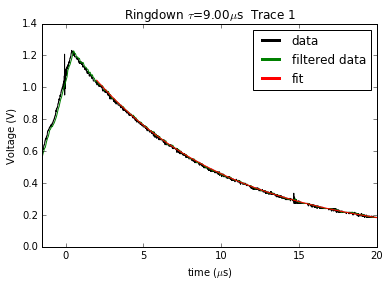

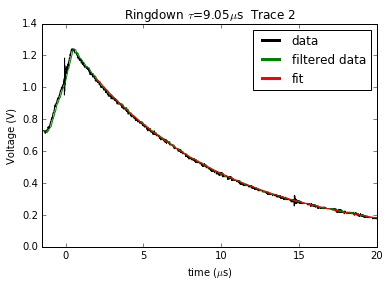

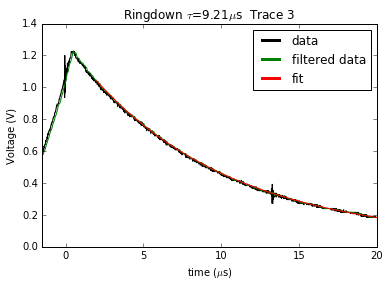

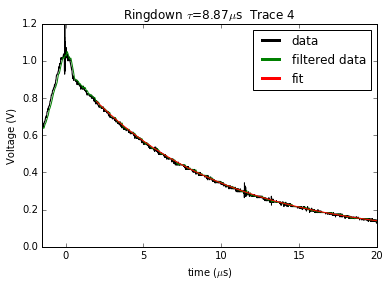

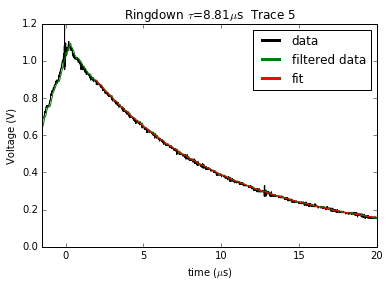

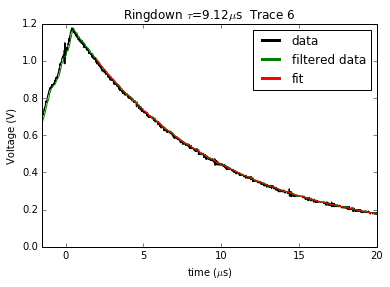

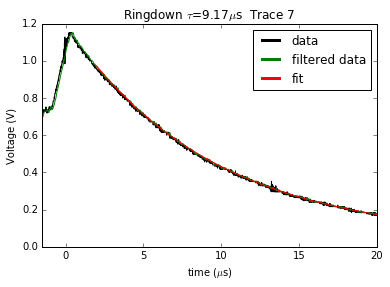

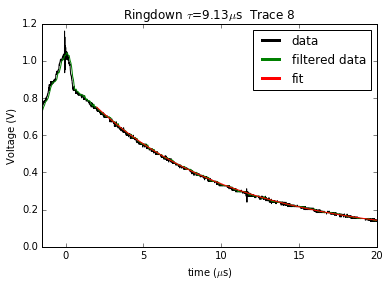

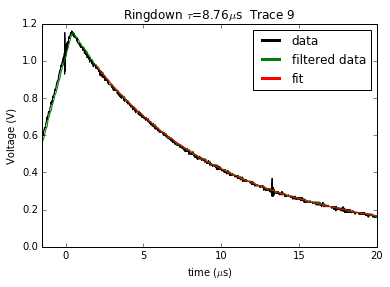

In [2]:
%matplotlib inline
n_traces=100

reload(instrument)
scope=instrument.AgilentScope("/dev/usbtmc0")
tau_mean,tau_uncertainty,series=scope.measure_tau(n_traces)

for j in range(min(n_traces,10)):
    series.plot_ringdown(j)

Connected to Agilent Technologies,DSO1012A,CN50301202,00.04.06 SP05

Tau is (9.09 +/- 0.01)us with std 0.16us


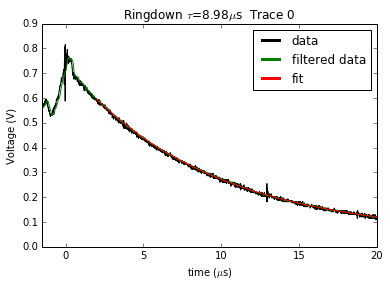

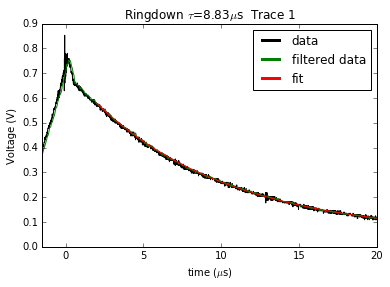

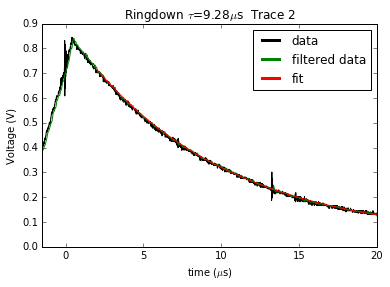

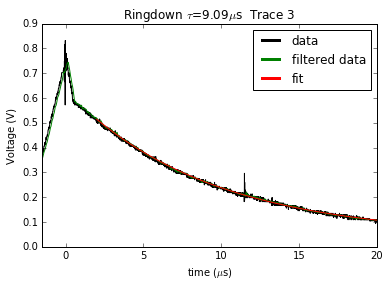

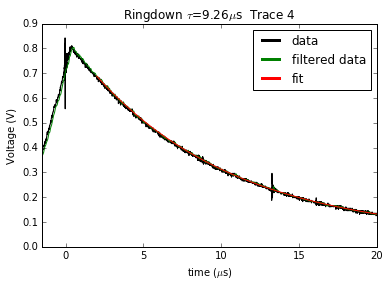

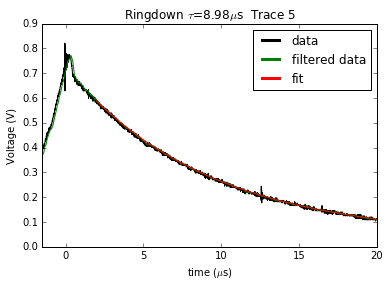

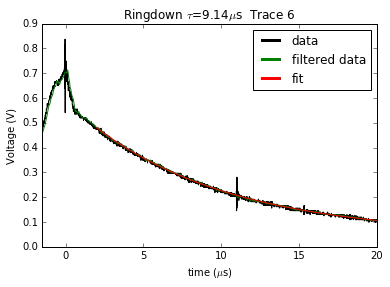

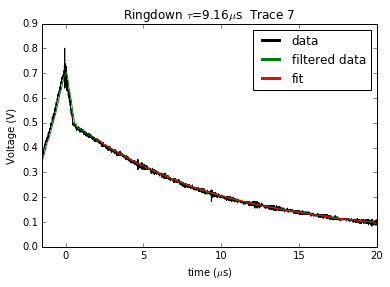

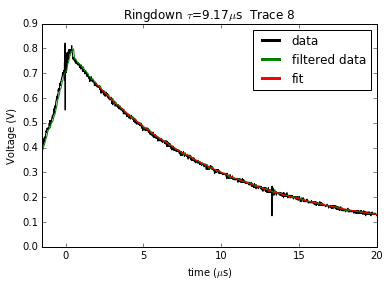

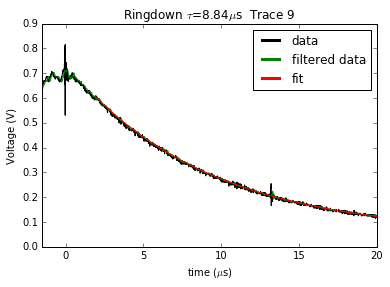

In [8]:
%matplotlib inline
n_traces=10000

reload(instrument)
scope=instrument.AgilentScope("/dev/usbtmc0")
tau_mean,tau_uncertainty,series=scope.measure_tau(n_traces)

for j in range(min(n_traces,10)):
    series.plot_ringdown(j)

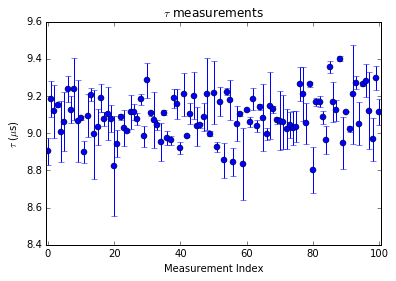

In [9]:
series.plot_tau_series(2)

Connected to Agilent Technologies,DSO1012A,CN50301202,00.04.06 SP05

Tau is (7.46 +/- 0.00)us with std 0.15us


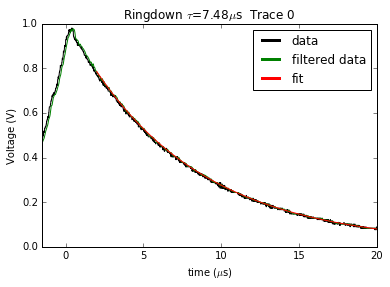

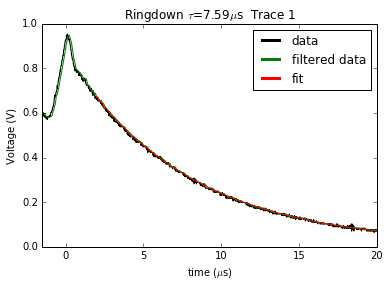

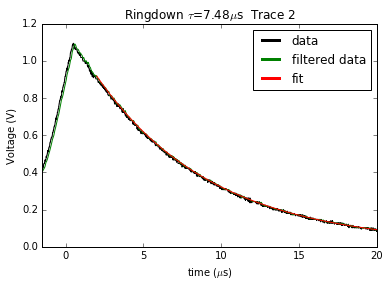

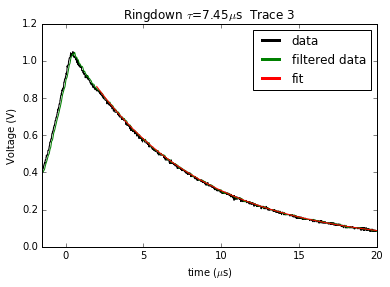

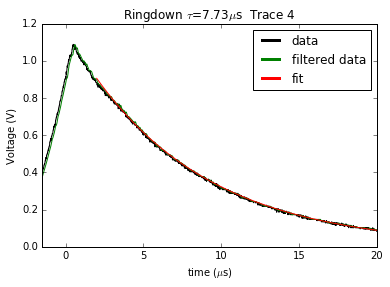

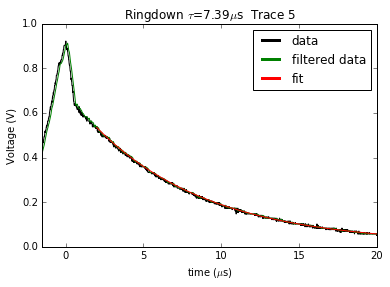

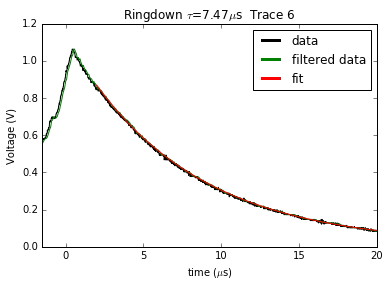

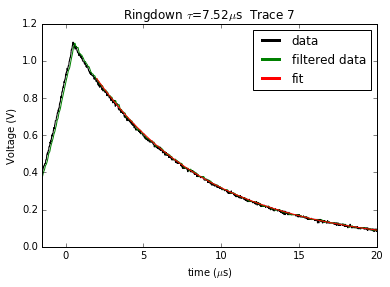

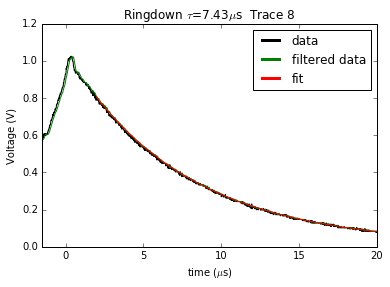

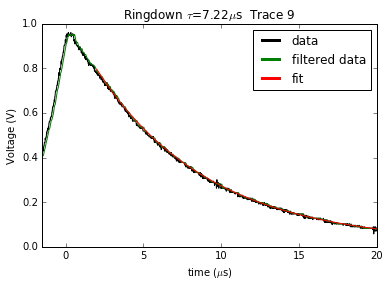

In [5]:
%matplotlib inline
n_traces=1000

reload(instrument)
scope=instrument.AgilentScope("/dev/usbtmc0")
tau_mean,tau_uncertainty,series=scope.measure_tau(n_traces)

for j in range(min(n_traces,10)):
    series.plot_ringdown(j)

Connected to Agilent Technologies,DSO1012A,CN50301202,00.04.06 SP05

Tau is (2.82 +/- 0.00)us with std 0.04us


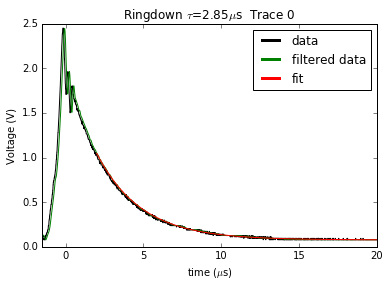

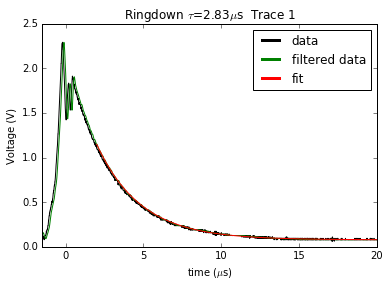

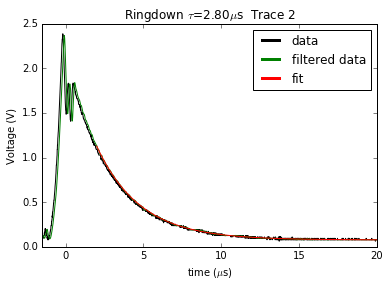

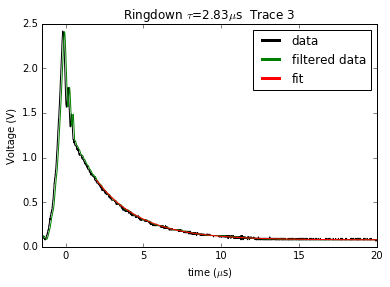

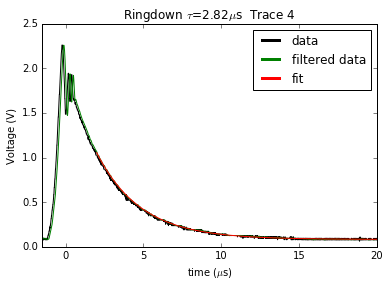

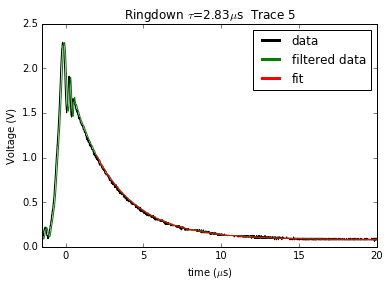

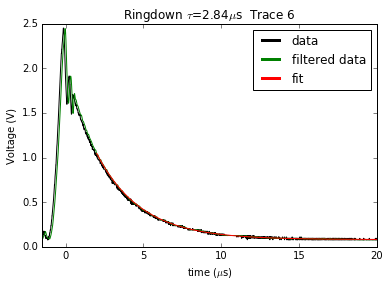

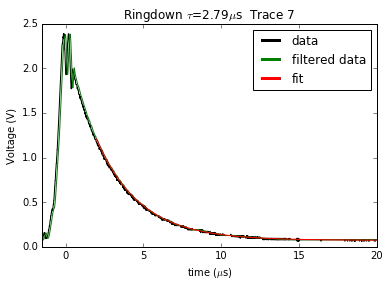

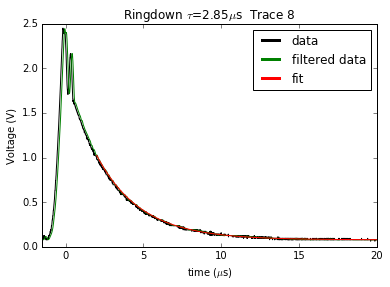

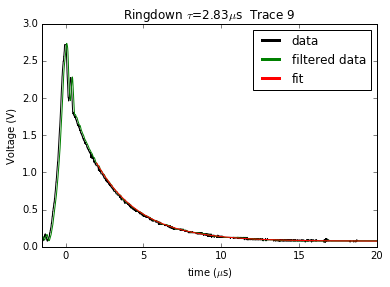

In [6]:
#Measuring lifetime of 2015 Mirrors 3 and 4 after micrometer measurements
%matplotlib inline
n_traces=100

reload(instrument)
scope=instrument.AgilentScope("/dev/usbtmc0")
tau_mean,tau_uncertainty,series=scope.measure_tau(n_traces)

for j in range(min(n_traces,10)):
    series.plot_ringdown(j)
    

series.file_name='2015_Mirrors_3_4_after_micrometer.pkl'
series.save()

Connected to Agilent Technologies,DSO1012A,CN50301202,00.04.06 SP05

Tau is (12.02 +/- 0.02)us with std 0.49us


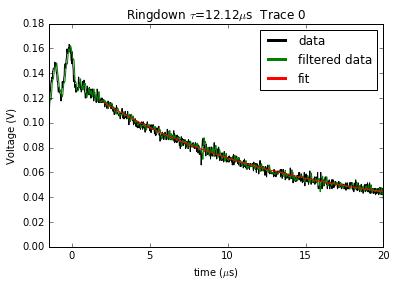

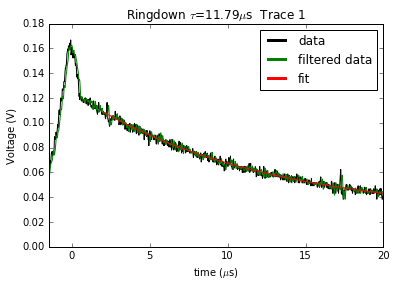

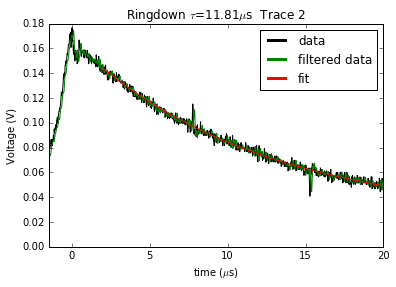

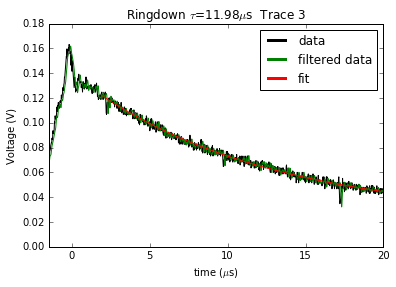

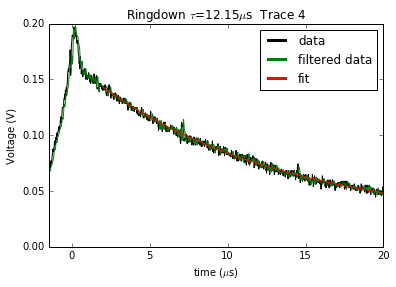

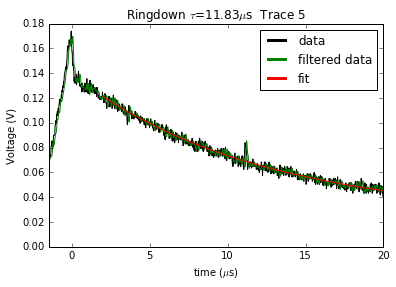

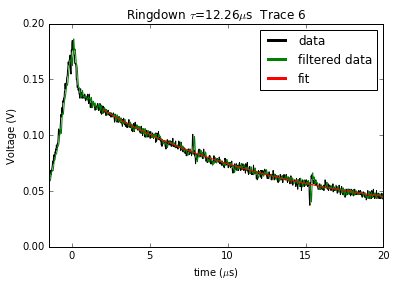

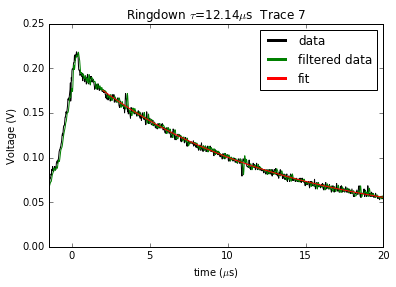

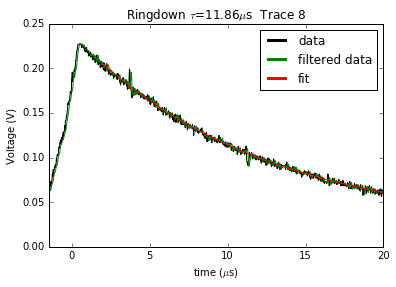

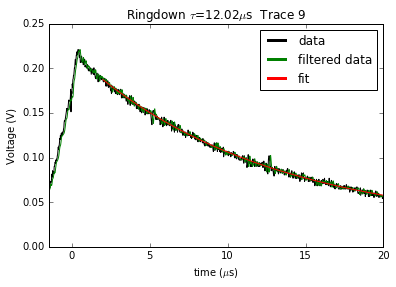

In [29]:
#Measuring lifetime of Monika's Mirrors 1 and 2 after micrometer measurements
%matplotlib inline
n_traces=1000

reload(instrument)
scope=instrument.AgilentScope("/dev/usbtmc0")
tau_mean,tau_uncertainty,series=scope.measure_tau(n_traces)

for j in range(min(n_traces,10)):
    series.plot_ringdown(j)
    
series.file_name='Monika_1_2_after_micrometer.pkl'
series.save()

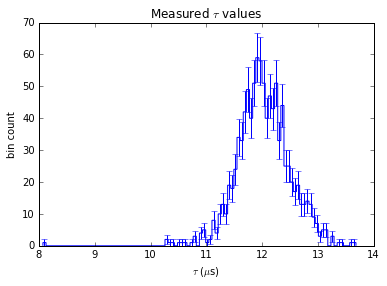

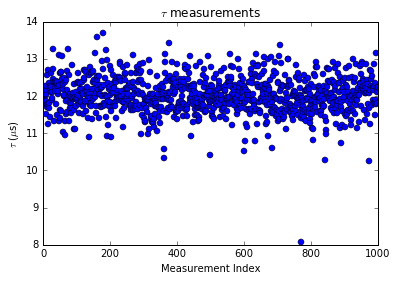

In [31]:
series.plot_tau_histogram(n_bins=100)
series.plot_tau_series(bin_size=1)

Connected to Agilent Technologies,DSO1012A,CN50301202,00.04.06 SP05

Tau is (40.13 +/- 0.02)us with std 0.59us


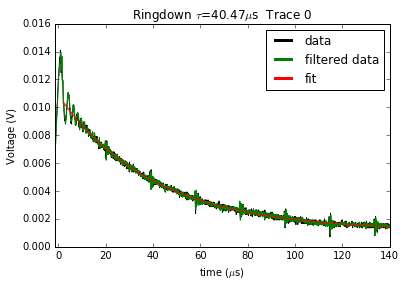

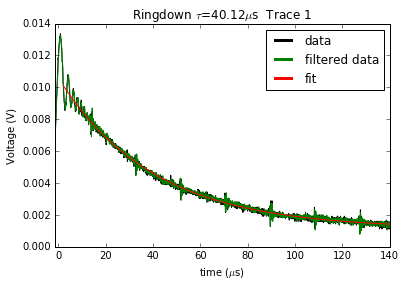

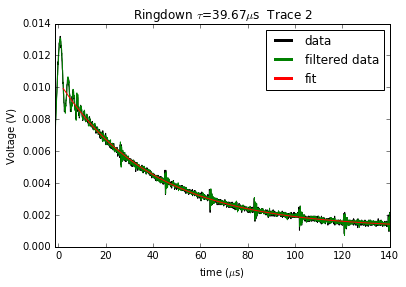

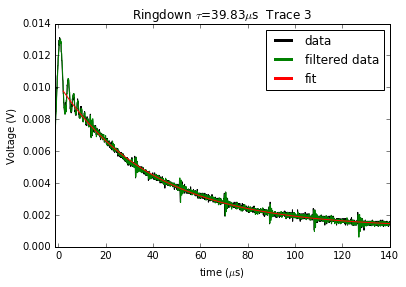

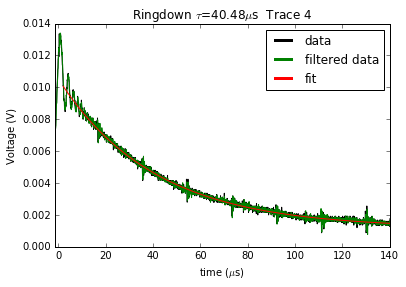

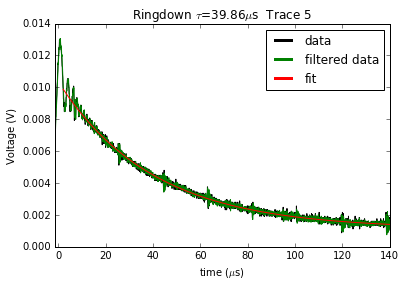

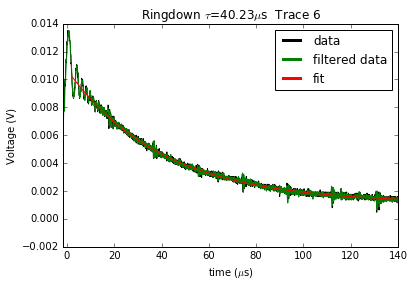

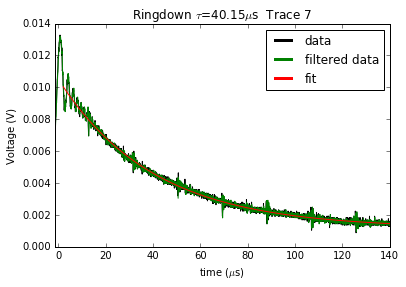

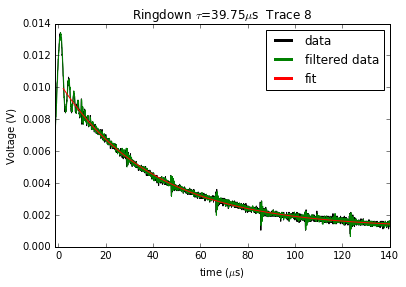

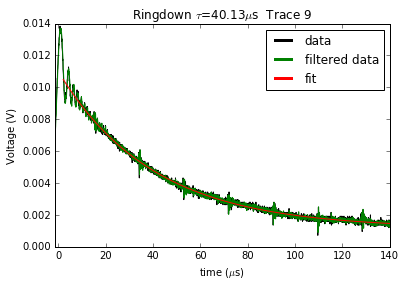

In [17]:
#Measuring lifetime of Monika's Mirrors 1 and 2 after micrometer measurements at 1560nm
%matplotlib inline
n_traces=1000

reload(instrument)
scope=instrument.AgilentScope("/dev/usbtmc0")
tau_mean,tau_uncertainty,series=scope.measure_tau(n_traces)

for j in range(min(n_traces,10)):
    series.plot_ringdown(j)
    
#Scanning Vpp=5V Voff=2.5V 10Hz into Hamamatsu G12180-005A with 2kOhm on resistor hox
series.file_name='Monika_1_2_1560_2e3ohms_10Hz.pkl'
series.save()

Connected to Agilent Technologies,DSO1012A,CN50301202,00.04.06 SP05

Tau is (39.01 +/- 0.13)us with std 1.30us


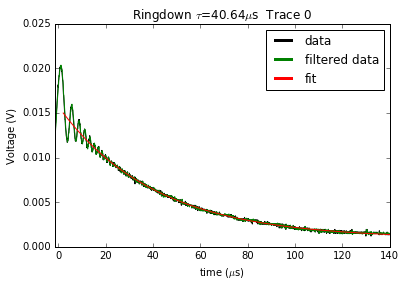

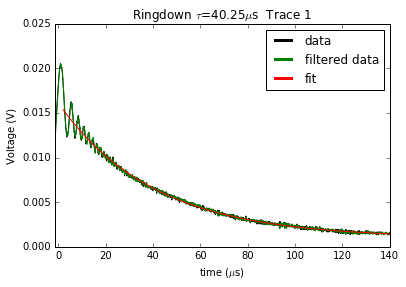

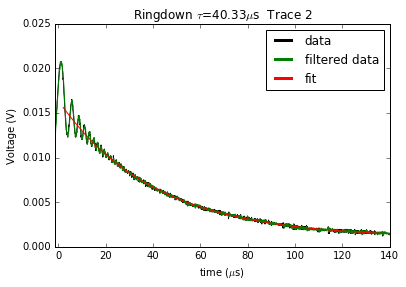

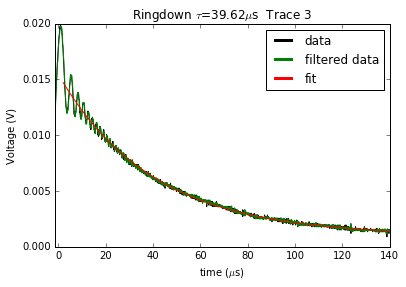

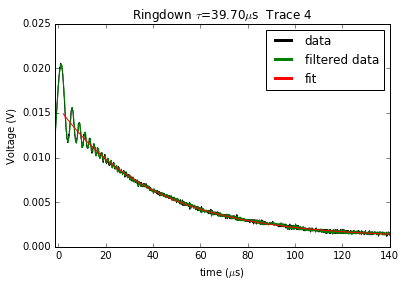

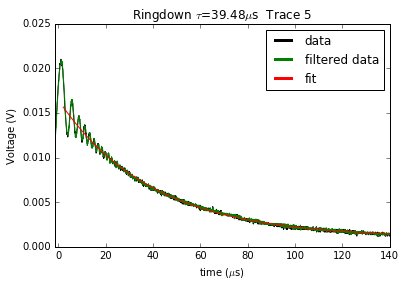

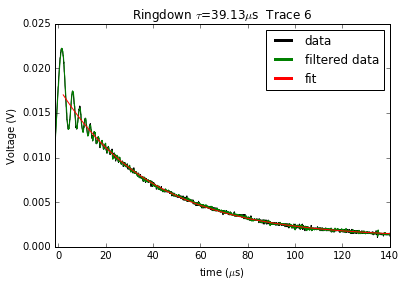

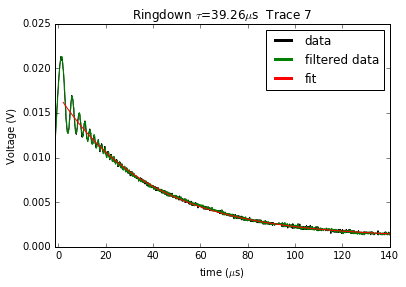

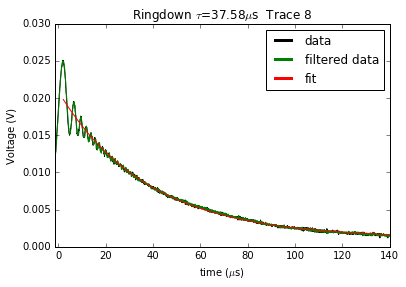

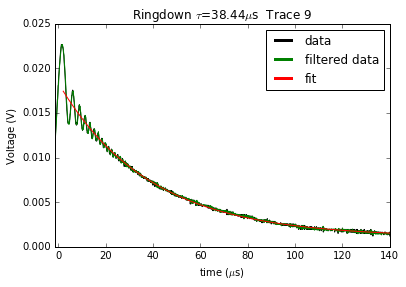

In [20]:
#Measuring lifetime of Monika's Mirrors 1 and 2 after micrometer measurements at 1560nm
%matplotlib inline
n_traces=100

reload(instrument)
scope=instrument.AgilentScope("/dev/usbtmc0")
tau_mean,tau_uncertainty,series=scope.measure_tau(n_traces)

for j in range(min(n_traces,10)):
    series.plot_ringdown(j)
    
#Scanning Vpp=5V Voff=2.5V 5Hz into Hamamatsu G12180-005A with 2kOhm on resistor hox
series.file_name='Monika_1_2_1560_2e3ohms_5Hz.pkl'
series.save()

Connected to Agilent Technologies,DSO1012A,CN50301202,00.04.06 SP05

Tau is (42.72 +/- 0.17)us with std 1.70us


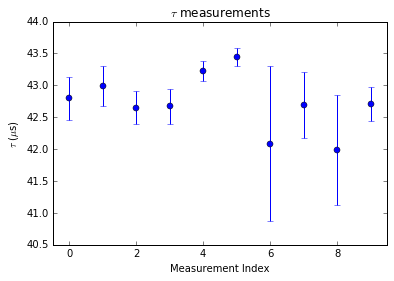

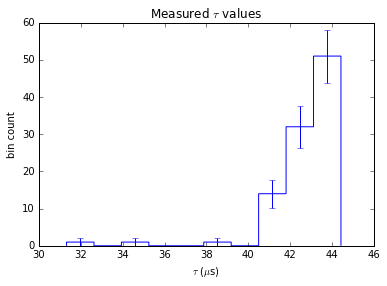

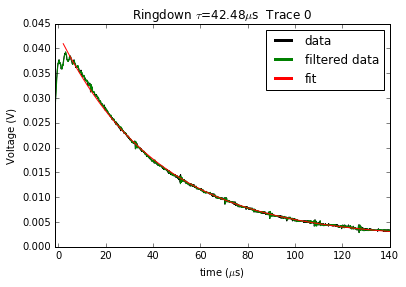

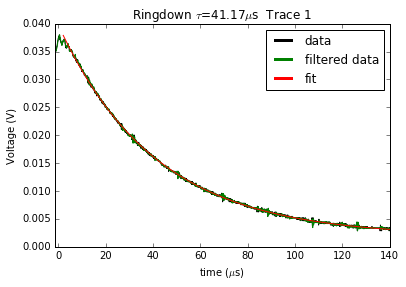

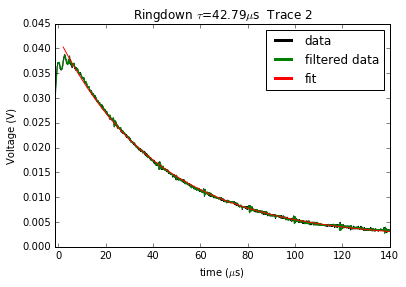

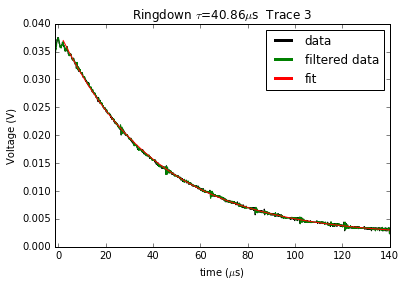

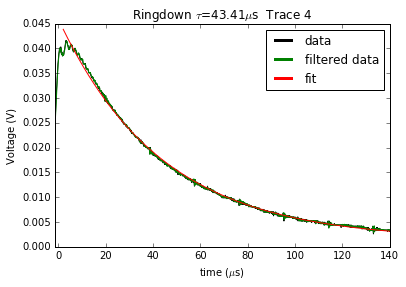

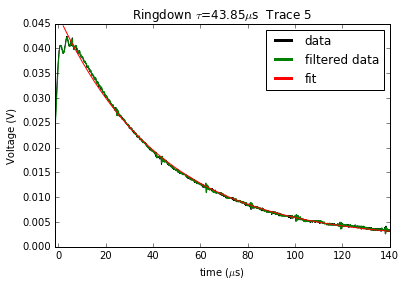

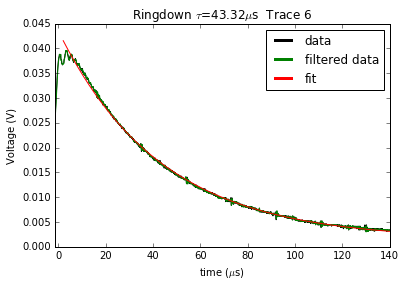

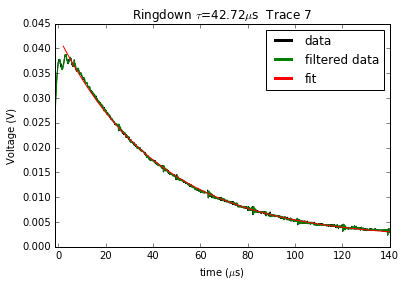

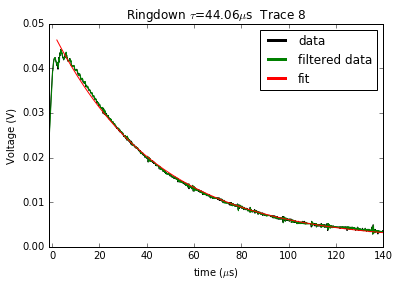

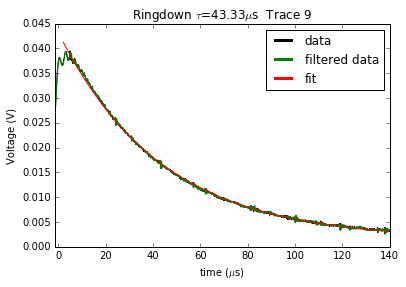

In [31]:
#Measuring lifetime of Monika's Mirrors 1 and 2 after micrometer measurements at 1560nm
%matplotlib inline
n_traces=100

reload(instrument)
scope=instrument.AgilentScope("/dev/usbtmc0")
tau_mean,tau_uncertainty,series=scope.measure_tau(n_traces)

#Make plots
series.plot_tau_series()
series.plot_tau_histogram()
for j in range(min(n_traces,10)):
    series.plot_ringdown(j)
    
#Scanning Vpp=5V Voff=2.5V 10Hz into Hamamatsu G12180-005A with 10kOhm on resistor hox
series.file_name='Monika_1_2_1560_10e3ohms_10Hz.pkl'
series.save()

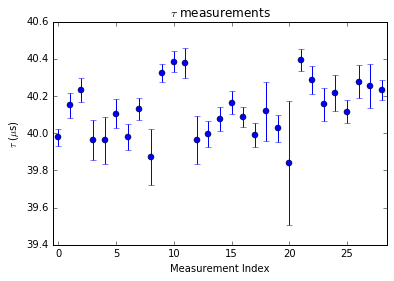

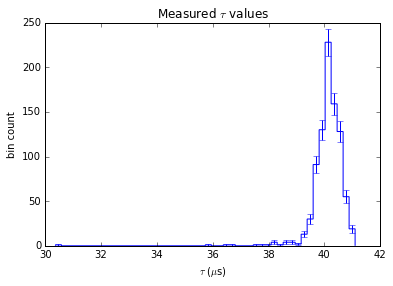

In [34]:
#To get the ringdown code to work for these long lifetimes, I had to change some Measurement_Series attribues.
#I changed right_plot_limit and right_fit_limit to 140us
#filter_cutoff was changed down to 5MHz
#criteria_voltage_min was dropped down to 0
#Still don't have a 1560 AOM, so these were made just by sweeping the laser frequency

series1=instrument.Measurement_Series.load('Monika_1_2_1560_2e3ohms_10Hz.pkl')
series1.plot_tau_series(bin_size=30)
series1.plot_tau_histogram(n_bins=50)

In [22]:
def chart_line_780(T,tau):
    """Given T in ppm and tau in us, returns a bunch of info for 780nm"""
    T1=T*1e-6
    T2=T*1e-6
    tau=tau*1e-6
    L=0.044 #cavity length (m)
    w0=45e-6 #cavity waist (m)
    c=2.9979e8 #speed of light (m/s)
    FSR=c/(2*L) #Free spectral range
    k=2*pi/780e-9 #wave vector magnitude (1/m)
    leakage=2*L/(c*tau)
    F=2*pi/leakage #Finesse
    l1_l2=leakage-T1-T2 #Scattering/absorption losses
    l_T_ratio=(l1_l2)/(T1+T2) #Scattering/absorption to Transmission ratio
    eta=24*(F/pi)/(k**2*w0**2) #Cavity cooperativity
    Gamma=FSR/F #Linewidth (Hz)
    return (T,tau*1e6,leakage*1e6,l_T_ratio,F,eta,Gamma)

def chart_line_1560(T,tau):
    """Given T in ppm and tau in us, returns a bunch of info for 1560nm"""
    T1=T*1e-6
    T2=T*1e-6
    tau=tau*1e-6
    L=0.044 #cavity length (m)
    w0=63.5e-6 #cavity waist (m)
    c=2.9979e8 #speed of light (m/s)
    FSR=c/(2*L) #Free spectral range
    k=2*pi/1560e-9 #wave vector magnitude (1/m)
    leakage=2*L/(c*tau)
    F=2*pi/leakage #Finesse
    l1_l2=leakage-T1-T2 #Scattering/absorption losses
    l_T_ratio=(l1_l2)/(T1+T2) #Scattering/absorption to Transmission ratio
    eta=24*(F/pi)/(k**2*w0**2) #Cavity cooperativity
    Gamma=FSR/F #Linewidth (Hz)
    return (T,tau*1e6,leakage*1e6,l_T_ratio,F,eta,Gamma)

chart_line_780(55.0/2.0,4.5)

(27.5,
 4.5,
 65.23084677792973,
 0.18601539596235878,
 96322.3017565586,
 5.600059769300791,
 35367.765131532295)

In [23]:
L=0.044 #cavity length (m)
w0=63.5e-6 #cavity waist (m)
c=2.9979e8 #speed of light (m/s)
FSR=c/(2*L) #Free spectral range
1/(FSR*65e-6) * 1e6

4.515981700010521

Connected to Agilent Technologies,DSO1012A,CN50301202,00.04.06 SP05

Tau is (2.90 +/- 0.01)us with std 0.10us


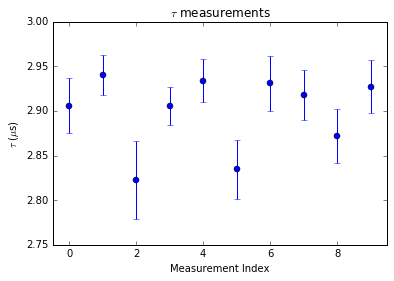

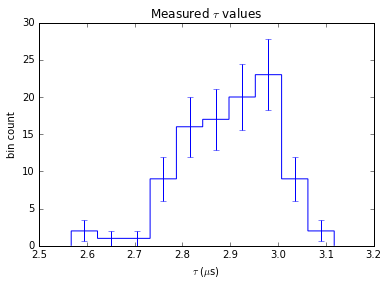

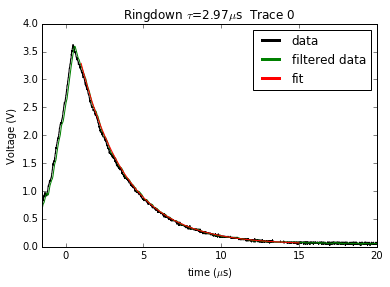

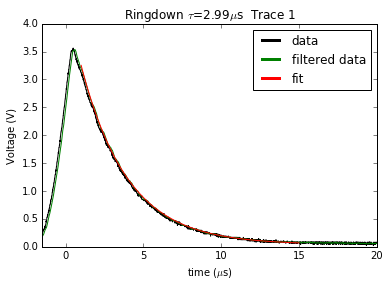

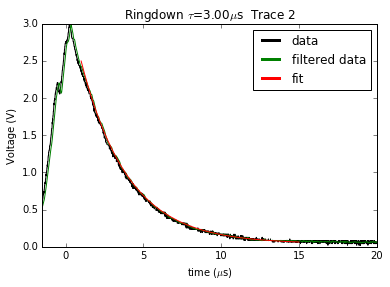

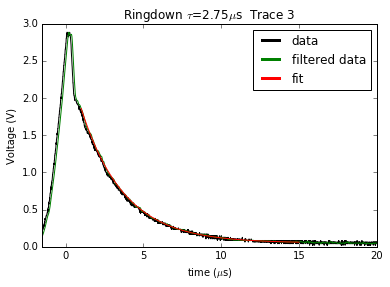

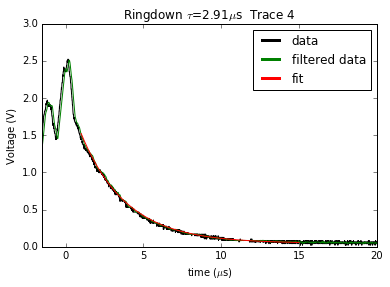

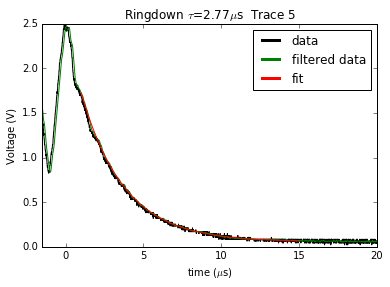

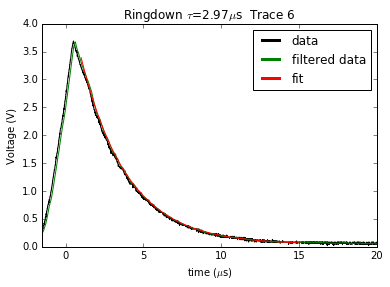

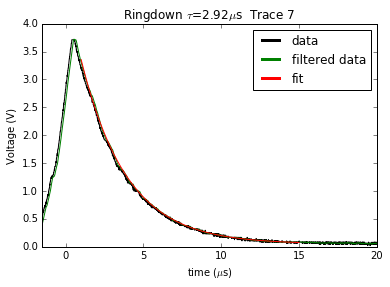

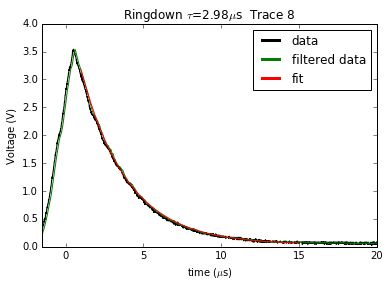

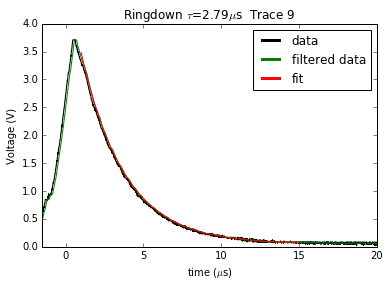

In [16]:
#Measuring lifetime of 2015 Mirrors 2 and 3 at 780nm before trying to lock to them at 1560nm
%matplotlib inline
n_traces=100

reload(instrument)
scope=instrument.AgilentScope("/dev/usbtmc0")
tau_mean,tau_uncertainty,series=scope.measure_tau(n_traces)

#Make plots
series.plot_tau_series()
series.plot_tau_histogram()
for j in range(min(n_traces,10)):
    series.plot_ringdown(j)
    
#Scanning Vpp=10V Voff=0V 80Hz into 780nm APD
series.file_name='2015_2_3_780_80Hz.pkl'
series.save()